In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import nlopt
from matplotlib import pyplot as plt

mp.verbosity(0)
Si = mp.Medium(index=5)
SiO2 = mp.Medium(index=1)

In [2]:
resolution = 100

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [-1.5, 0, 0]
source_size = mp.Vector3(0, 2, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

design_region_resolution = 100
Nx = design_region_resolution + 1
Ny = design_region_resolution + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN",do_averaging=False)
design_region = mpa.DesignRegion(
    design_variables, volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
)


geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 0.5, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(y=Sy / 4), material=Si, size=mp.Vector3(0.5, Sy / 2, 0)
    ),  # vertical waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
    # mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
    #         e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
    #
    # The commented lines above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; We give an alternative approach to impose symmetry in later tutorials.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

TE_top = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(0, 1, 0), size=mp.Vector3(x=2)), mode=1
)
ob_list = [TE_top]


def J(alpha):
    return npa.abs(alpha) ** 2


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
)

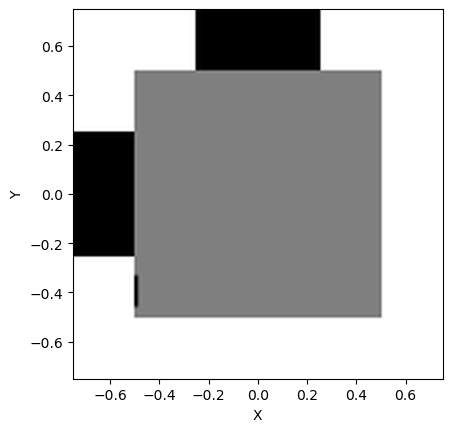

In [3]:
x0 =  np.ones((Nx*Ny,))*0.5
middle_index = (Nx * Ny) // 2
x0[4:17] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(False, output_plane = mp.Volume(size = (1.5, 1.5, 0), center = (0,0,0)))
plt.show()

FloatProgress(value=0.0, description='0% done ', max=10.0)

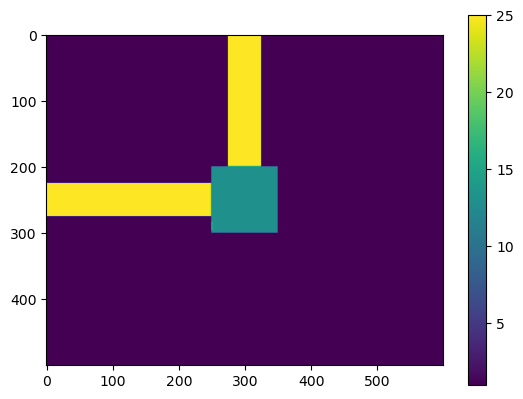

In [4]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(Sx*resolution, Sy*resolution)))));
plt.colorbar()

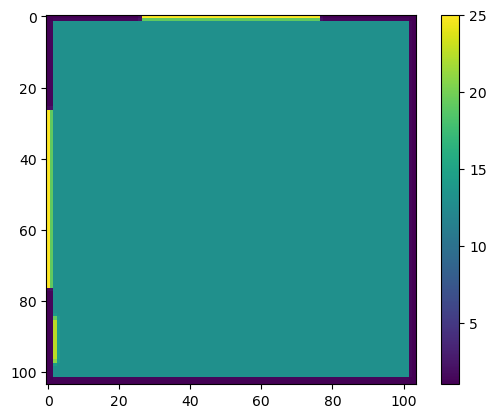

In [5]:
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))),)
plt.colorbar()

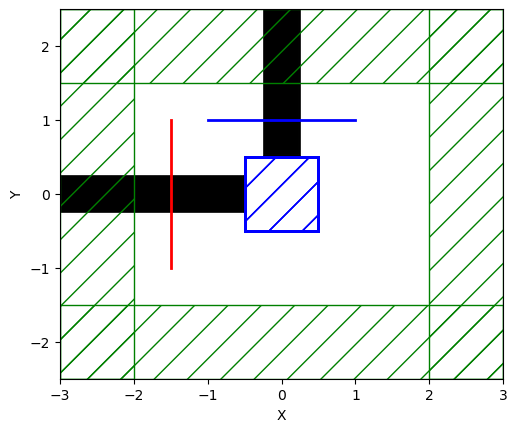

In [6]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
# x0[21] = 1
# x0[22] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

FloatProgress(value=100.0, description='0% done ', max=200.0, min=100.0)

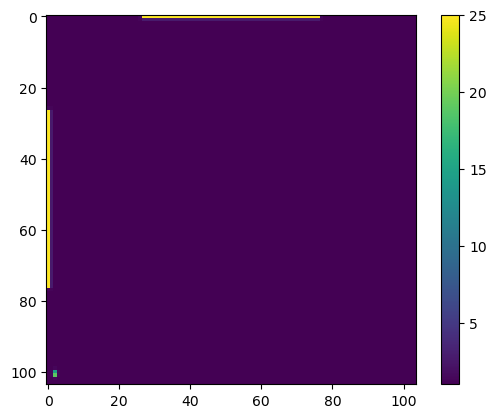

In [8]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=100)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))),)
plt.colorbar()

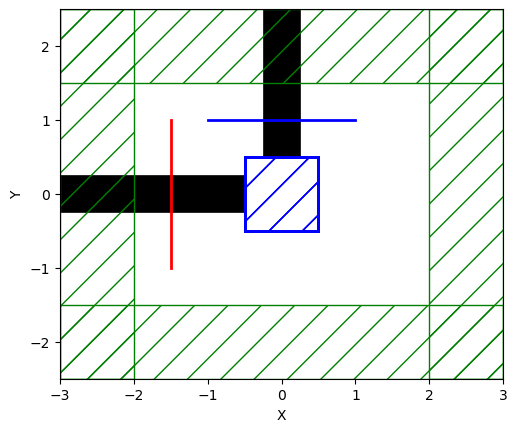

In [ ]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
x0[21] = 1
# x0[22] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

FloatProgress(value=200.0, description='0% done ', max=300.0, min=200.0)

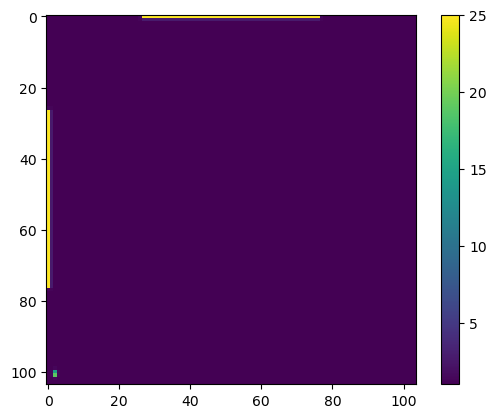

In [9]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=100)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))),)
plt.colorbar()

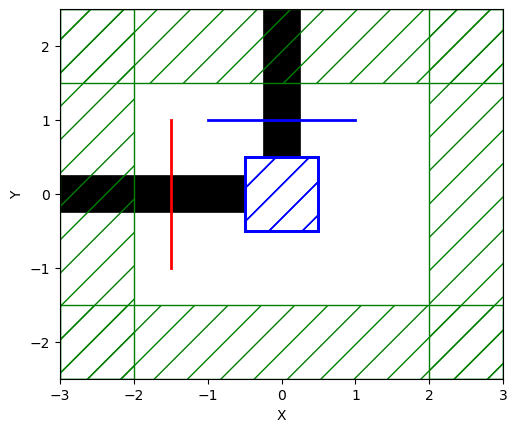

In [ ]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
x0[21] = 1
x0[22] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

FloatProgress(value=0.0, description='0% done ', max=10.0)

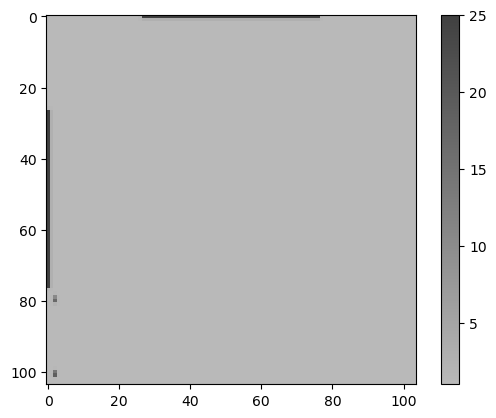

In [ ]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))),)
plt.colorbar()

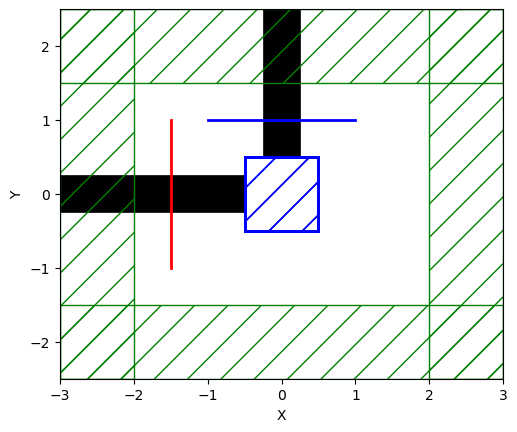

In [ ]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
x0[21] = 1
x0[22] = 1

# x0[42] = 1
# x0[43] = 1


x0[63] = 1
x0[64] = 1

x0[84] = 1
x0[85] = 1

x0[126] = 1
x0[127] = 1

x0[147] = 1
x0[148] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

FloatProgress(value=0.0, description='0% done ')

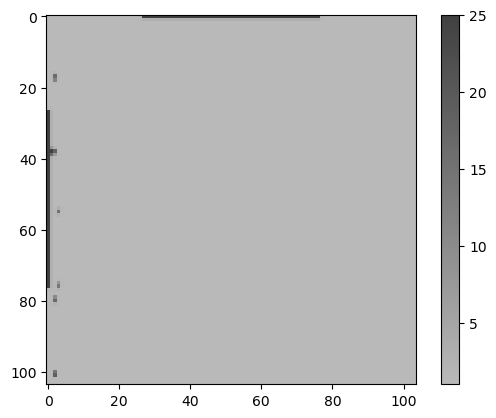

In [ ]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=100)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))),)
plt.colorbar()

In [ ]:
print(cropped_x[2,2])
print(cropped_x[5,2])
print(cropped_x[8,2])

18.91994461841245
1.0
1.0


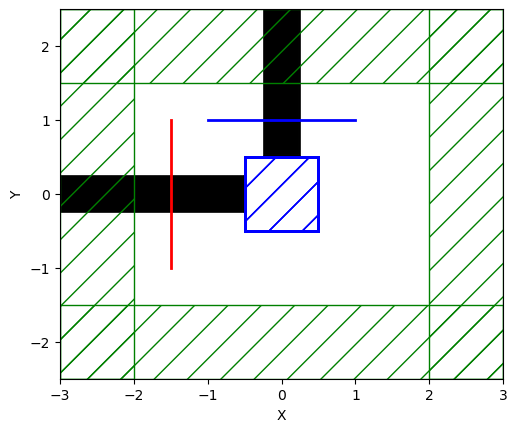

In [ ]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
x0[21] = 1
x0[22] = 1

# x0[42] = 1
# x0[43] = 1

x0[73] = 1
x0[74] = 1

x0[94] = 1
x0[95] = 1


x0[63] = 1
x0[64] = 1

x0[84] = 1
x0[85] = 1

x0[126] = 1
x0[127] = 1

x0[147] = 1
x0[148] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

FloatProgress(value=0.0, description='0% done ', max=10.0)

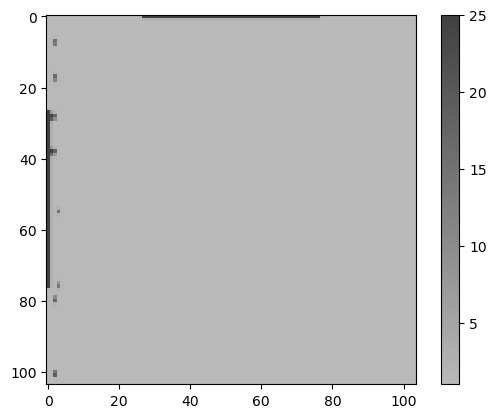

In [ ]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))),)
plt.colorbar()

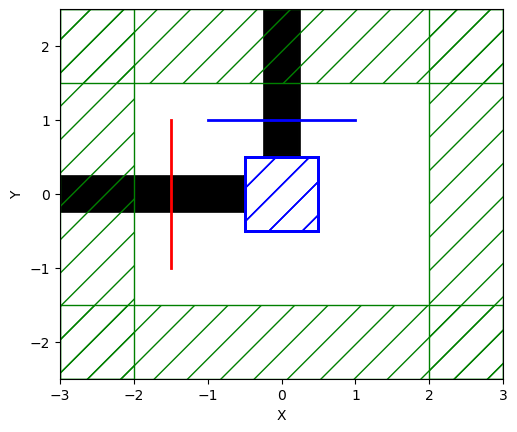

In [ ]:
x0 =  np.ones((Nx*Ny,))*0
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
x0[21] = 1
x0[22] = 1

# x0[42] = 1
# x0[43] = 1
x0[52] = 1
x0[53] = 1


x0[73] = 1
x0[74] = 1

x0[94] = 1
x0[95] = 1


x0[63] = 1
x0[64] = 1

x0[84] = 1
x0[85] = 1

x0[126] = 1
x0[127] = 1

x0[147] = 1
x0[148] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

FloatProgress(value=0.0, description='0% done ', max=10.0)

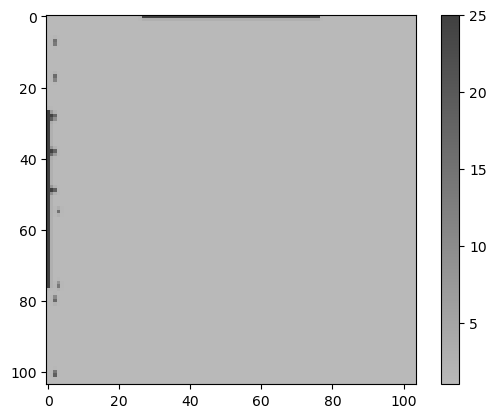

In [ ]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
# x의 중앙 부분을 Nx, Ny 크기로 잘라내기
Sx, Sy = x.shape[:2]  # x가 더 높은 차원을 가지고 있다면, 이를 수정해야 할 수 있습니다.
center_x, center_y = Sx // 2, Sy // 2

# Nx, Ny가 홀수인 경우
half_Nx, half_Ny =  Nx // 2, Ny // 2

# 중앙에서 Nx, Ny 크기만큼 잘라내기
cropped_x = x[(center_x - half_Nx - 2):(center_x + half_Nx + 2), (center_y - half_Ny - 2):(center_y + half_Ny + 2)]

# 잘라낸 부분을 90도 회전시키고 표시하기
plt.imshow(np.rot90(np.squeeze(np.abs(cropped_x.reshape(Nx+3, Ny+3)))),)
plt.colorbar()

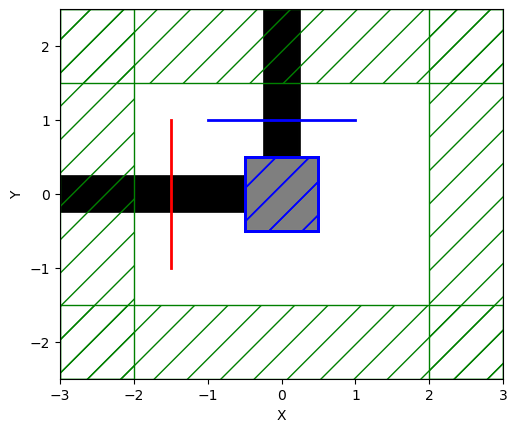

In [ ]:
x0 =  np.ones((Nx*Ny,))*0.5
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

In [ ]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(Sx*resolution, Sy*resolution)))),);
plt.colorbar()

FloatProgress(value=0.0, description='0% done ', max=10.0)

ValueError: cannot reshape array of size 300000 into shape (60000,50000)

In [ ]:
x0 =  np.ones((Nx*Ny,))*0.5
middle_index = (Nx * Ny) // 2
x0[0] = 1
x0[1] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

In [ ]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(Sx*resolution, Sy*resolution)))));
plt.colorbar()

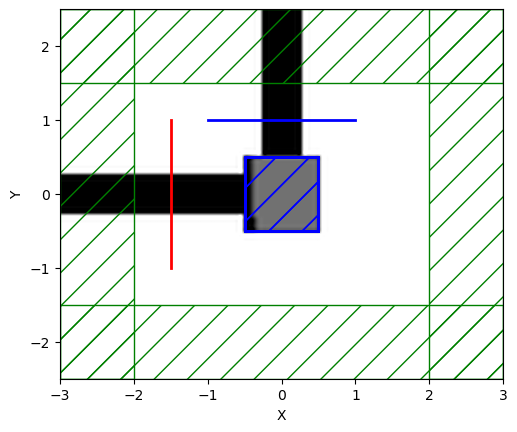

In [ ]:
x0 =  np.ones((Nx*Ny,))*0.5
middle_index = (Nx * Ny) // 2
x0[0:46] = 1
# x0[middle_index+1] = 1
# x0[middle_index+2] = 1
opt.update_design([x0])

opt.plot2D(True)
plt.show()

FloatProgress(value=0.0, description='0% done ', max=10.0)

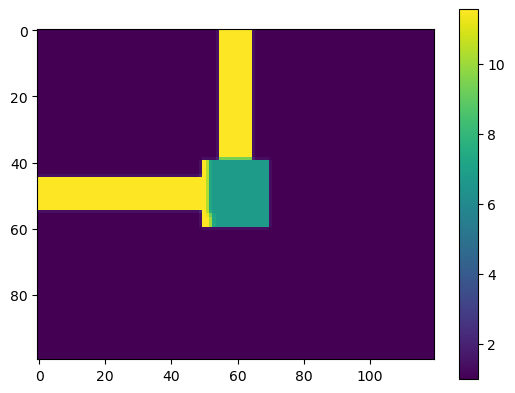

In [ ]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)
x=sim.get_epsilon()
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(Sx*resolution, Sy*resolution)))));
plt.colorbar()

In [ ]:
x0 = np.array([0, 0, 0, 1, 1, 0, 0, 0, 0])
opt.update_design([x0])

opt.plot2D(True)
plt.show()

ValueError: weights of shape 1681 do not match user specified grid dimension: Vector3<41.0, 41.0, 1>

In [ ]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)

FloatProgress(value=0.0, description='0% done ', max=10.0)

In [ ]:
x=sim.get_epsilon()

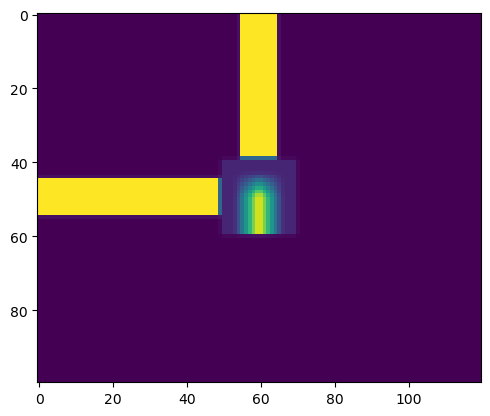

In [ ]:
plt.imshow(np.rot90(np.squeeze(x.reshape(Sx*resolution, Sy*resolution))));

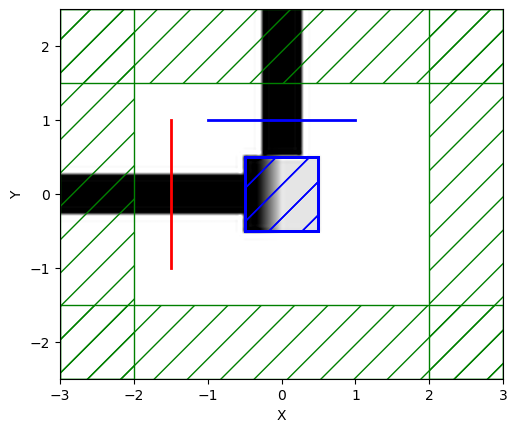

In [ ]:
x0 = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0])
opt.update_design([x0])

opt.plot2D(True)
plt.show()

In [ ]:
sim.run(mp.at_beginning(mp.output_epsilon(frequency=1/0.7)),until=10)

FloatProgress(value=0.0, description='0% done ', max=10.0)

In [ ]:
x=sim.get_epsilon()

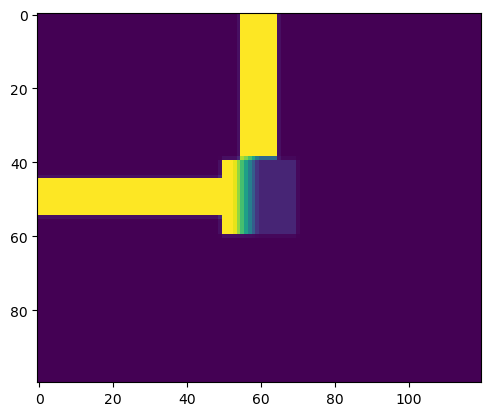

In [ ]:
plt.imshow(np.rot90(np.squeeze(np.abs(x.reshape(Sx*resolution, Sy*resolution)))));